In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal
from project.sheaf_diffusion import sheaf_diffusion
from project.sheaf_simultaneous_sparse import sheaf_gradient_flow
from project.sheaf_simultaneous_potential_xdeltaAflow import sheaf_gradient_flow_potential_xdeltaA

In [5]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [6]:
graph = to_networkx(data)

In [7]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [8]:
#    def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, mask, use_act, augmented, add_lp, add_hp, dropout,input_dropout, learning_rate = 0.01):
#         def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, learning_rate = 0.01):
#    def __init__(self, graph, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, potential, mask, use_act, augmented, add_lp, add_hp, dropout, input_dropout, perturb_diagonal, allow_neg_potential, learning_rate = 0.01):

model_diffusion = sheaf_gradient_flow_potential_xdeltaA(graph, 183, 2, graph.number_of_edges(), 2, 4, 1703,5, 3, False, True, 'radial', mask, True,True,True,True, 0.1,0.1,False, False, False, False, 0.001)

In [9]:
#model_diffusion

In [10]:
wandb_logger_diffusion = WandbLogger(project="sheaf_potential_xdeltaAflow")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [11]:
early_stop_callback = EarlyStopping(monitor="val_acc", min_delta=0.000, patience=200, verbose=False, mode='max')
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-potential-xdeltaAflow-{epoch:02d}-{val_loss:.2f}-{val_acc:.2f}",
    save_top_k=10,
    mode="max",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [12]:
sheaf_dm = SheafDataModule_ForGraphs(data, 10 , 1)

In [13]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger_diffusion,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [14]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2` reached.
LR finder stopped early after 2 steps due to diverging loss.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_23a826ca-fc8b-439f-92b0-0abc9d237a75.ckpt


Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


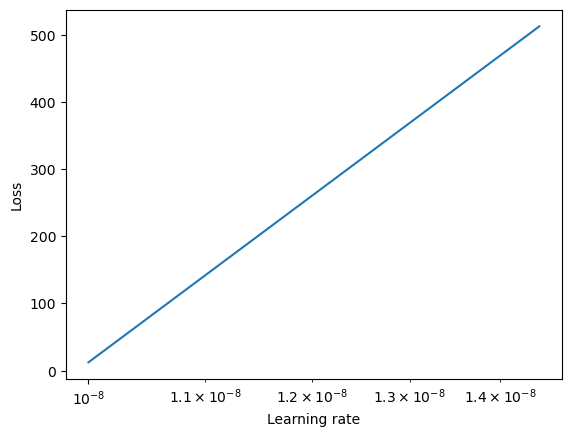

In [15]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [16]:
new_lr = lr_finder.suggestion()
model_diffusion.hparams.learning_rate = 0.01
model_diffusion.learning_rate = 0.01
#model_diffusion.hparams.learning_rate = new_lr
#model_diffusion.learning_rate = new_lr

Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


In [17]:
trainer.fit(model_diffusion, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /root/projects/temp_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type          | Params
-------------

Sanity Checking: 0it [00:00, ?it/s]

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [18]:
trainer.test(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7027026414871216
        test_loss           1.1670796871185303
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.1670796871185303, 'test_acc': 0.7027026414871216}]

In [ ]:
torch.diag(1.+5*torch.ones(3))

In [19]:
import torch
from torch_sparse import coalesce

In [23]:
index = torch.tensor([[1, 0, 1, 0, 2, 1],
                      [0, 1, 1, 1, 0, 0]])
value = torch.Tensor([1,2,3,4,5,6])

index, value = coalesce(index, value, m=3, n=2)

In [24]:
index

tensor([[0, 1, 1, 2],
        [1, 0, 1, 0]])

In [25]:
value

tensor([6., 7., 3., 5.])